In [1]:
# Imports

from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

from astropy.convolution import Box1DKernel, convolve, Gaussian1DKernel, convolve_fft
from astropy.units import cds

from scipy import ndimage
#from skimage.measure import label

import matplotlib as mpl

/opt/anaconda3/envs/AstroStats/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
subset = pd.read_csv('hon_catalog_subset.csv')
subset

,Unnamed: 0,TIC,numax,e_numax,Tmag,Teff,e_Teff,Rstar,e_Rstar,Lstar,e_Lstar,Dist,e_Dist,RUWE,Flag,_RA,_DE,numax_bin
0,45239,140578874,37.3,2.5,8.0,4883,97,10.9,0.5,60.3,2.6,0.421,0.002,1.00,1,68.030649,-77.477397,1
1,46693,142305400,93.2,3.9,6.0,4787,95,6.6,0.3,20.5,0.6,0.105,0.000,0.88,1,41.387298,-42.838700,3
2,47925,144066888,59.1,3.3,8.0,5011,100,10.3,0.4,59.6,2.1,0.429,0.003,0.97,1,337.610637,-51.552294,2
3,49523,147565895,57.5,2.9,6.0,4750,95,7.5,0.3,25.6,0.8,0.113,0.000,1.05,1,163.680210,-42.018147,2
4,53314,155896371,91.5,3.8,8.0,4723,94,7.4,0.3,24.2,0.9,0.274,0.001,0.98,1,4.098704,-51.611425,3
5,59412,167169718,60.3,3.8,10.0,4788,95,7.5,0.4,26.7,1.5,0.686,0.005,1.01,1,97.008341,-66.627249,2
6,63033,176982730,31.4,2.2,10.0,4692,93,11.0,0.5,52.6,2.0,0.954,0.009,1.00,1,101.522427,-67.798416,1
7,80732,235906010,133.4,11.2,10.0,4796,95,5.3,0.2,13.3,0.4,0.489,0.003,1.07,1,290.352529,80.756842,4
8,96927,278702671,27.4,5.4,12.0,4846,96,10.1,0.5,50.8,3.6,2.420,0.076,1.00,1,334.579903,-41.530806,1
9,97637,279615774,124.6,5.6,8.0,4922,98,6.0,0.3,19.2,0.8,0.237,0.004,7.32,1,106.341828,-59.391192,4


In [3]:
# FUNCTIONS: to generate power spectra

def HighPassFilter(lc, highpass_filter = 4, method = 'Flatten', normalize = True):
    if method == 'Flatten':
        # High-pass filter. Default filter width is 4 days (attenuates frequency below 3 microHz)
        window_length =  int(np.shape(lc)[0]/((lc.time.value[-1]-lc.time.value[0])/highpass_filter))
    
        window_length = window_length ## get rid of the dimensions and convert to an int
        if window_length % 2 == 0:
            window_length += 1
    
        lc_corr = lc.flatten(window_length)
        
        if normalize:
            lc_corr = lc_corr.normalize(unit = 'ppm')
    
    elif method == 'Gaussian':
        filter_width = int(np.shape(lc)[0]/((lc.time.value[-1]-lc.time.value[0])/highpass_filter))
        
        high_passed = Gaussian_high_pass_filter(lc.flux.value, window_size = filter_width)

        lc_dict = {'time': lc.time.value, 'flux': high_passed *1.e3* cds.ppm}
        
        lc_corr = lk.LightCurve(lc_dict)

    lc_final = lc_corr.remove_outliers(3)
    
    return lc_final

def PSD(lc, sector = None, numax_est = None, min_freq = 3, max_freq = 280, oversample = 5):
    
    psd = lc.to_periodogram(method='lombscargle', normalization='psd', maximum_frequency = max_freq, minimum_frequency = min_freq, oversample_factor = oversample)
    
    return psd

def ps_smooth(frequency, power, numax_est, evol_stage, sm):
    """ This function should be executed after ps_no_slope """
    if evol_stage == 'RGB':
        dnu_est = 0.3*(numax_est)**0.75
    elif evol_stage == 'RHB':
        dnu_est = 0.3*(numax_est)**0.86
    elif evol_stage == 'AGB':
        dnu_est = 0.3*(numax_est)**0.77

    resolution = frequency[1] - frequency[0]

    ## following code taken from pysyd target function line 693
    if sm == None:
        numax_sun = 3090.00
        sm = 4.*(numax_est/numax_sun)**0.2
        if sm < 1.:
            sm = 1.


    sig = (sm*(dnu_est/resolution))/np.sqrt(8.0*np.log(2.0))
    # print(sig)   # sig is same as pySYD
    pssm = convolve_fft(np.copy(power), Gaussian1DKernel(int(sig)))


    return pssm

def txt_to_LC(file, label = None, normalised = True):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import lightkurve as lk
    from  lightkurve import periodogram
    from astropy import units as u
    from astropy.units import cds
    from astropy.time import Time
    
    time = file['time']
    flux = file['flux']
    
    time = Time(time, scale='tdb', format='btjd')

    if normalised == True:
        flux = flux * cds.ppm           # assign units of ppm for normalised lc
    else:
        flux = flux * u.electron/u.s           # assign units of ppm for non-normalised lc
    
    lc_dict = {'time': time, 'flux': flux}
    lc = lk.LightCurve(lc_dict)
    return lc

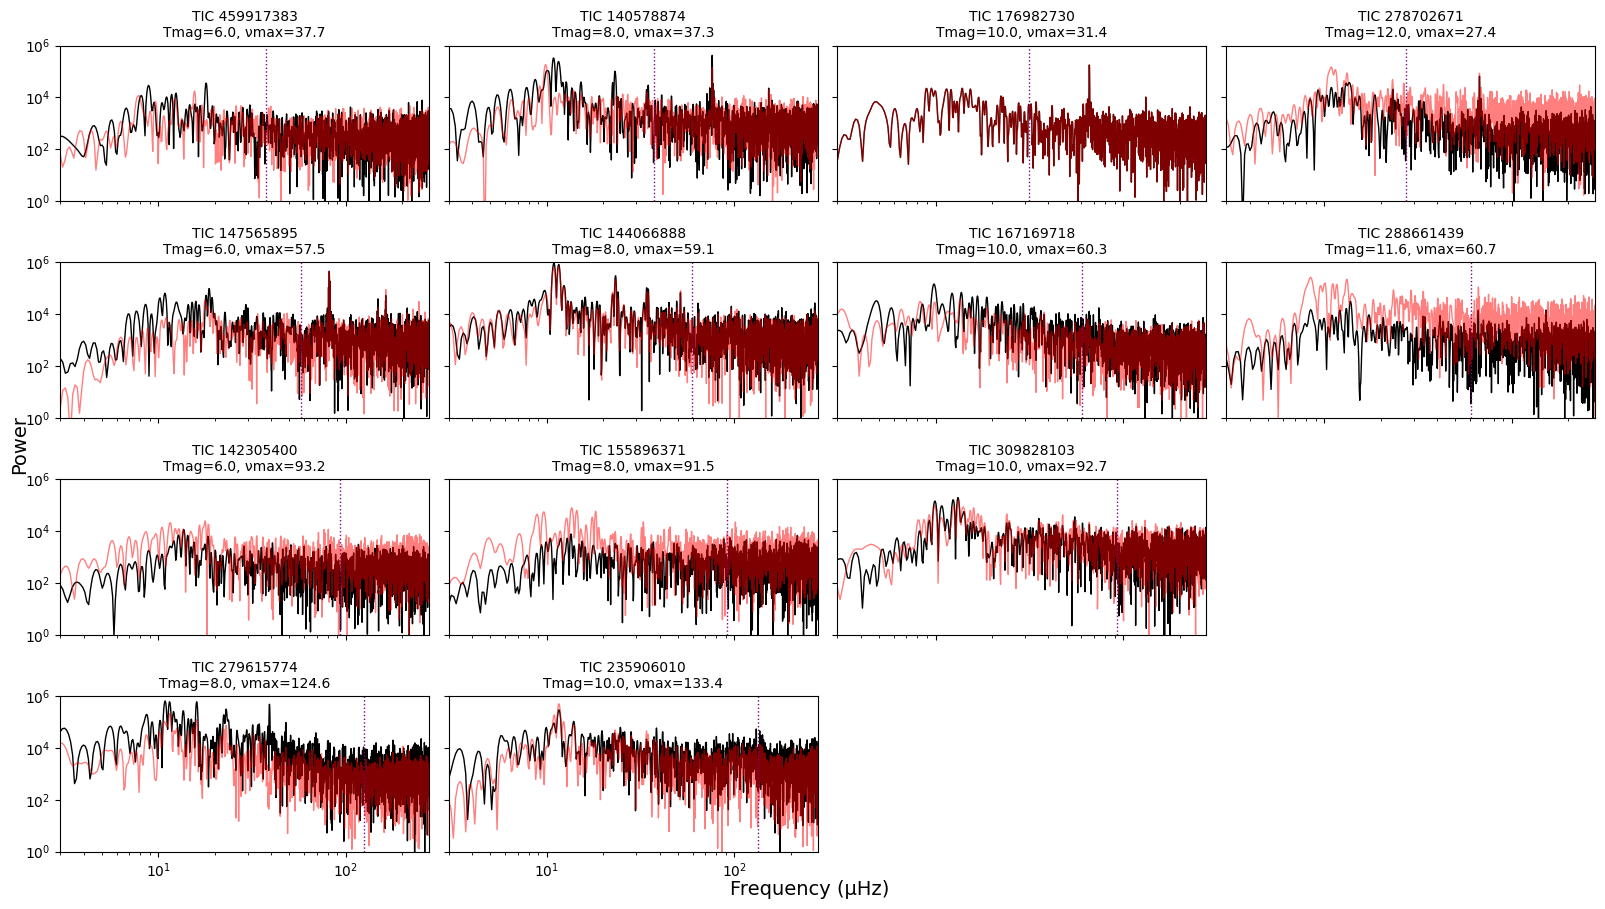

In [4]:
# --- Define numax bins manually (edges can be tuned as needed)
bins = [0, 45, 75, 105, 150]  # Rough boundaries for 30, 60, 90, 120 μHz
labels = [1, 2, 3, 4]
subset['numax_bin'] = pd.cut(subset['numax'], bins=bins, labels=labels, include_lowest=True)

# --- Sort each bin by decreasing brightness (smaller Tmag = brighter)
binned_rows = []
for label in labels:
    bin_df = subset[subset['numax_bin'] == label].sort_values('Tmag', ascending=True)
    binned_rows.append(bin_df)

# --- Define grid shape (4x4)
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9), sharex=True, sharey=True)

# --- Optional: define empty positions for rows with fewer stars
# Row 3 → 3 stars (one empty)
# Row 4 → 2 stars (two empty)
empty_indices = [(2, 3), (3, 2), (3, 3)]

# --- Loop over grid positions
for r in range(nrows):
    for c in range(ncols):
        ax = axes[r, c]

        # Skip predefined empty slots
        if (r, c) in empty_indices:
            ax.axis('off')
            continue

        # Get star for this position if available
        try:
            row = binned_rows[r].iloc[c]
        except (IndexError, KeyError):
            ax.axis('off')
            continue

        tic = row['TIC']
        numax = row['numax']
        tmag = row['Tmag']

        directory = f'pipeline_outputs/TIC{int(tic)}/'
        lc_cls = pd.read_csv(f'{directory}corrected_lc_adaptive1.csv')
        lc_3x3 = pd.read_csv(f'{directory}corrected_lc_3x3.csv')

        # --- Build PSD (assuming you already defined these functions)
        lclc_cls = txt_to_LC(lc_cls)
        lclc_cls_hp = HighPassFilter(lclc_cls, highpass_filter=2, method='Flatten', normalize=True)
        psd_cls = PSD(lclc_cls_hp, sector=None, numax_est=numax,
                      min_freq=3, max_freq=0.5*1e6*(1/1800), oversample=5)
        lclc_3x3 = txt_to_LC(lc_3x3)
        lclc_3x3_hp = HighPassFilter(lclc_3x3, highpass_filter=2, method='Flatten', normalize=True)
        psd_3x3 = PSD(lclc_3x3_hp, sector=None, numax_est=numax,
                      min_freq=3, max_freq=0.5*1e6*(1/1800), oversample=5)

        freq1 = psd_cls.frequency.value
        power1 = psd_cls.power.value
        freq2 = psd_3x3.frequency.value
        power2 = psd_3x3.power.value

        ax.loglog(freq1, power1, color='k', lw=1)
        ax.loglog(freq2, power2, color='r', lw=1, alpha=0.5)
        ax.set_title(f"TIC {int(tic)}\nTmag={tmag:.1f}, νmax={numax:.1f}", fontsize=10)
        ax.set_ylim(1e0, 1e6)
        ax.set_xlim(3e0, 0.5*1e6*(1/1800))
        ax.axvline(numax, c='purple', lw=1., ls=':')

# --- Label axes
fig.text(0.5, 0.00, 'Frequency (µHz)', ha='center', fontsize=14)
fig.text(0.00, 0.5, 'Power', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
plt.savefig('reproduce_fig19.png', dpi=300)
plt.show()

In [5]:
# FUNCTIONS: to generate background corrected power spectra

from astropy.convolution import Box1DKernel, convolve, Gaussian1DKernel, convolve_fft

def ps_smooth(frequency, power, numax_est, sm):
    """ This function should be executed after ps_no_slope """
    
    dnu_est = 0.3*(numax_est)**0.75
    
    resolution = frequency[1] - frequency[0]

    ## following code taken from pysyd target function line 693
    if sm == None:
        numax_sun = 3090.00
        sm = 4.*(numax_est/numax_sun)**0.2
        if sm < 1.:
            sm = 1.


    sig = (sm*(dnu_est/resolution))/np.sqrt(8.0*np.log(2.0))
    # print(sig)   # sig is same as pySYD
    pssm = convolve_fft(np.copy(power), Gaussian1DKernel(int(sig)))


    return pssm

def get_PE_bounds(numax_est, lowerp, upperp):
    """ Get the boundaries of the power excess around the predicted numax """
    numax_sun = 3090.00
    width_sun = 1300.0
    #Get power excess mask
    width = width_sun*(numax_est/numax_sun)
    maxpower = [numax_est-(width), numax_est+(width)]

    if lowerp == None:
        lowerp = maxpower[0]

    if upperp == None:
        upperp = maxpower[1]

    ps_bounds = [lowerp, upperp]

    return ps_bounds
    
def get_linear_bg(frequency, power, numax_est, sm=2, lowerp = None, upperp = None):
    """
    Estimate the BG with a straight line. Linear in log!

    """
    smps = ps_smooth(frequency, power, numax_est, sm)

    ps_bounds = get_PE_bounds(numax_est, lowerp, upperp)
   

    #---Get vaules for linear fit:
    # print('PSMASK: ', ps_mask[0], ps_mask[1])
    mask = np.ma.getmask(np.ma.masked_inside(frequency, ps_bounds[0], ps_bounds[1]))
    smps = smps[mask]
    pwr1 = smps[0]
    
    pwr2 = smps[len(smps)-1]  #SWC: Get power values at start and end of excess region.
    # print('LINEARBG: pwr1, pwr2=',pwr1,pwr2)

    nu1 = ps_bounds[0]
    nu2 = ps_bounds[1]
    nu1 = np.log10(nu1)
    nu2 = np.log10(nu2)
    # print('LINEARBG: nu1,nu2=',nu1,nu2)


    offsetfrac = 0.0

    pwr1 = pwr1 - offsetfrac*pwr1
    pwr2 = pwr2 - offsetfrac*pwr1  #Move line down a bit.
    pwr1 = np.log10(pwr1)
    pwr2 = np.log10(pwr2)

    grad = (pwr2-pwr1)/(nu2-nu1)
    c = pwr1 - grad*nu1

    # print(f'Parameters of Linear Bkg model: grad = {grad}, c = {c}')


    # print('LINEARBG: offsetfrac, pwr1,pwr2,grad,c=',offsetfrac,pwr1,pwr2,grad,c)

    linbg = np.zeros(len(frequency))

    for i in range(len(frequency)):
        linbg[i] = 10.0**(grad*np.log10(frequency[i]) + c)
        #print('Linear BG, freq, i=',linbg[i],self.frequency[i],i)

    return linbg, ps_bounds

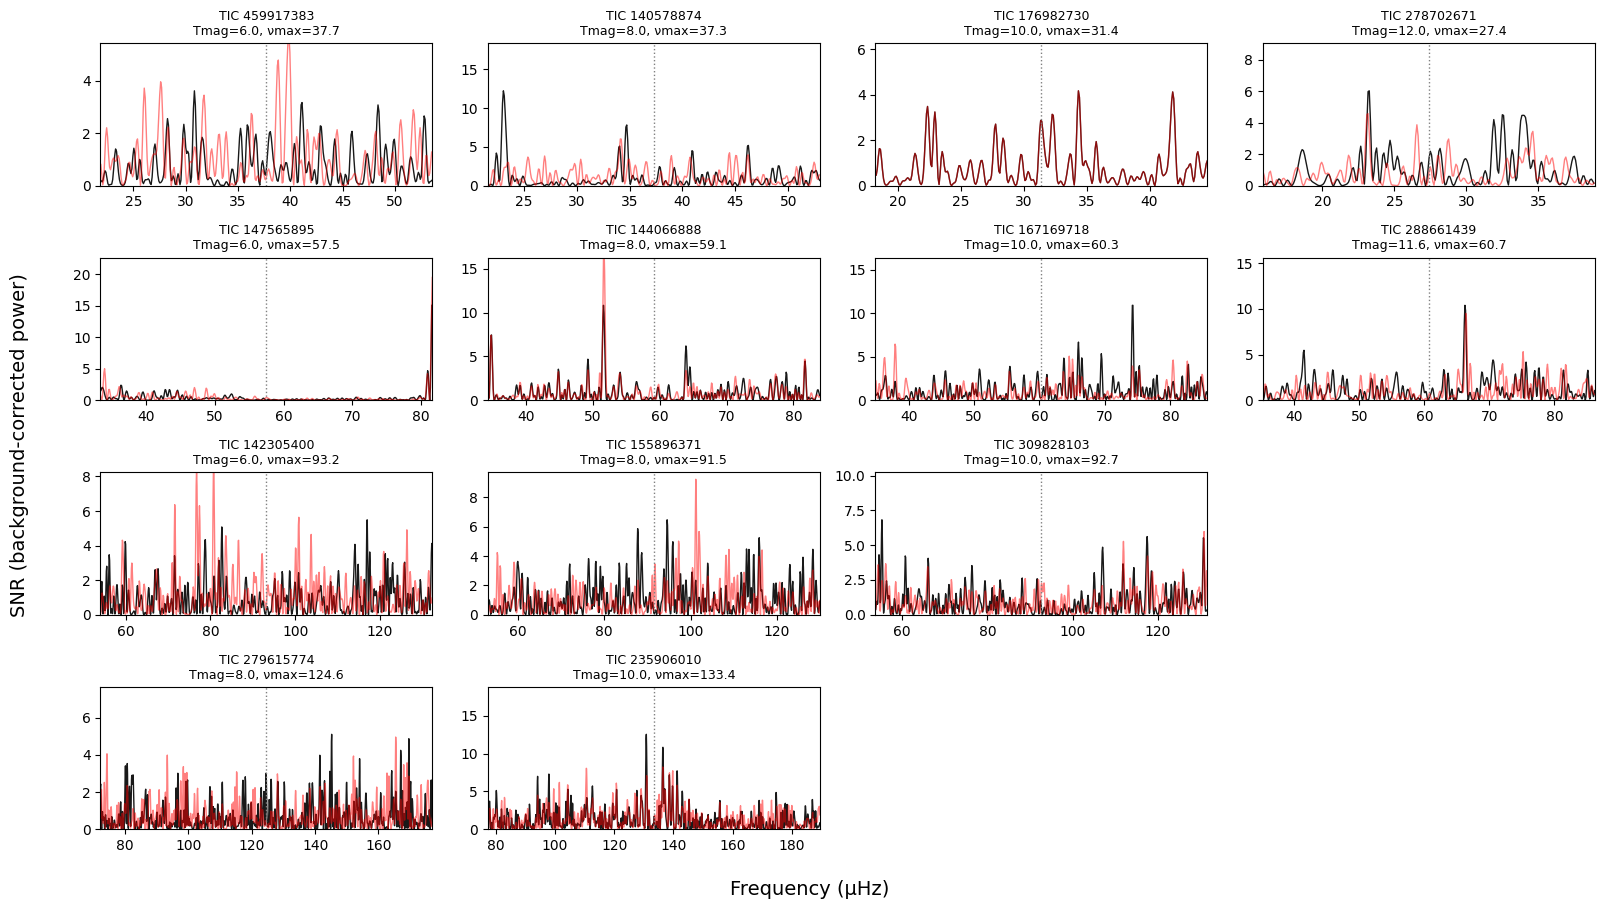

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Define numax bins manually (edges can be tuned as needed)
bins = [0, 45, 75, 105, 150]  # Rough boundaries for 30, 60, 90, 120 μHz
labels = [1, 2, 3, 4]
subset['numax_bin'] = pd.cut(subset['numax'], bins=bins, labels=labels, include_lowest=True)

# --- Sort each bin by decreasing brightness (smaller Tmag = brighter)
binned_rows = []
for label in labels:
    bin_df = subset[subset['numax_bin'] == label].sort_values('Tmag', ascending=True)
    binned_rows.append(bin_df)

# --- Define grid shape (4x4)
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9), sharex=False, sharey=False)

# --- Empty slots for incomplete rows
empty_indices = [(2, 3), (3, 2), (3, 3)]

for r in range(nrows):
    for c in range(ncols):
        ax = axes[r, c]
        if (r, c) in empty_indices:
            ax.axis('off')
            continue

        try:
            row = binned_rows[r].iloc[c]
        except (IndexError, KeyError):
            ax.axis('off')
            continue

        tic = int(row['TIC'])
        numax = row['numax']
        tmag = row['Tmag']
        directory = f'pipeline_outputs/TIC{tic}/'

        try:
            lc_cls = pd.read_csv(f'{directory}corrected_lc_adaptive1.csv')
            lc_3x3 = pd.read_csv(f'{directory}corrected_lc_3x3.csv')
        except FileNotFoundError:
            ax.axis('off')
            continue

        # --- Build PSDs
        lclc_cls = txt_to_LC(lc_cls)
        lclc_cls_hp = HighPassFilter(lclc_cls, highpass_filter=2, method='Flatten', normalize=True)
        psd_cls = PSD(lclc_cls_hp, sector=None, numax_est=numax,
                      min_freq=3, max_freq=0.5*1e6*(1/1800), oversample=5)

        lclc_3x3 = txt_to_LC(lc_3x3)
        lclc_3x3_hp = HighPassFilter(lclc_3x3, highpass_filter=2, method='Flatten', normalize=True)
        psd_3x3 = PSD(lclc_3x3_hp, sector=None, numax_est=numax,
                      min_freq=3, max_freq=0.5*1e6*(1/1800), oversample=5)

        # --- Background correction
        linbg_cls, ps_mask_cls = get_linear_bg(psd_cls.frequency.value, psd_cls.power.value, numax, sm=2)
        psd_bgcorr_cls = psd_cls.power.value / linbg_cls
        mask_cls = (psd_cls.frequency.value >= ps_mask_cls[0]) & (psd_cls.frequency.value <= ps_mask_cls[1])

        linbg_3x3, ps_mask_3x3 = get_linear_bg(psd_3x3.frequency.value, psd_3x3.power.value, numax, sm=2)
        psd_bgcorr_3x3 = psd_3x3.power.value / linbg_3x3
        mask_3x3 = (psd_3x3.frequency.value >= ps_mask_3x3[0]) & (psd_3x3.frequency.value <= ps_mask_3x3[1])

        # --- Plot background-corrected PSDs (SNR)
        ax.plot(psd_cls.frequency.value[mask_cls], psd_bgcorr_cls[mask_cls],
                c='k', lw=1, alpha=0.9, label='Adaptive')
        ax.plot(psd_3x3.frequency.value[mask_3x3], psd_bgcorr_3x3[mask_3x3],
                c='r', lw=1, alpha=0.5, label='3×3')

        # --- Find and mark largest peaks
        #peaks_cls, _ = find_peaks(psd_bgcorr_cls[mask_cls])
        #if len(peaks_cls) > 0:
        #    idx_cls = np.argmax(psd_bgcorr_cls[mask_cls][peaks_cls])
        #    peak_freq_cls = psd_cls.frequency.value[mask_cls][peaks_cls][idx_cls]
        #    peak_val_cls = psd_bgcorr_cls[mask_cls][peaks_cls][idx_cls]
        #    ax.scatter(peak_freq_cls, peak_val_cls, c='mediumpurple', zorder=10, s=20)

        #peaks_3x3, _ = find_peaks(psd_bgcorr_3x3[mask_3x3])
        #if len(peaks_3x3) > 0:
        #    idx_3x3 = np.argmax(psd_bgcorr_3x3[mask_3x3])
        #    peak_freq_3x3 = psd_3x3.frequency.value[mask_3x3][peaks_3x3][idx_3x3]
        #    peak_val_3x3 = psd_bgcorr_3x3[mask_3x3][peaks_3x3][idx_3x3]
        #    ax.scatter(peak_freq_3x3, peak_val_3x3, c='mediumpurple', zorder=10, s=20)

        # --- νmax line
        ax.axvline(numax, c='gray', ls=':', lw=1)

        # --- Labels
        ax.set_title(f"TIC {tic}\nTmag={tmag:.1f}, νmax={numax:.1f}", fontsize=9)
        ax.set_xlim(ps_mask_cls[0], ps_mask_cls[1])
        ax.set_ylim(0, np.nanmax(psd_bgcorr_cls[mask_cls]) * 1.5)

# --- Axis labels and layout
fig.text(0.5, 0.00, 'Frequency (µHz)', ha='center', fontsize=14)
fig.text(0.00, 0.5, 'SNR (background-corrected power)', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.03, 0.03, 1, 1])
plt.savefig('reproduce_fig19_bgcorr.png', dpi=300)
plt.show()


Looking at the generated images we can see some interesting things! TIC 176982730 has an exact match for both the adaptive and 3x3 aperture power spectrum. This is because the clustering algorithm identified the 3x3 box as the ideal aperture! It isn't necessarily clearn if the adaptive aperture performs better (by visual inspection) than the 3x3 aperture. In some cases (like TIC 235906010) the adaptive aperture effectively gets a higher SNR and maintains the frequency of maximum power identified by Hon et al. 2021. In other cases the 3x3 aperture has a higher signal. Although in many of these oscillation envelope isn't quite centered on $\nu_{\mathrm{max}}$ (if there even is a good signal), but that is likely more an issue of sector selection rather than aperture choice. 